# Body Posture Classifier - Analysis Notebook

This notebook provides an interactive environment for analyzing body posture data from video frames.

In [16]:
# Import required libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
from datetime import datetime
from collections import defaultdict

# Set up matplotlib for better display
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All libraries imported successfully!
OpenCV version: 4.11.0
NumPy version: 2.1.3


## 1. Data Exploration

In [17]:
# Explore the data directory structure
def explore_data_structure():
    data_dirs = ['Data/laying', 'Data/Sitting', 'Data/Standing']
    
    data_info = {}
    
    for dir_path in data_dirs:
        if os.path.exists(dir_path):
            video_files = [f for f in os.listdir(dir_path) if f.endswith('.mp4')]
            data_info[dir_path] = {
                'count': len(video_files),
                'files': video_files[:5],  
                'total_size_mb': sum(os.path.getsize(os.path.join(dir_path, f)) for f in video_files) / (1024*1024)
            }
            print(f"✅ {dir_path}: {len(video_files)} video files ({data_info[dir_path]['total_size_mb']:.1f} MB)")
        else:
            print(f"❌ {dir_path}: Directory not found")
    
    return data_info

data_info = explore_data_structure()

✅ Data/laying: 187 video files (90.5 MB)
✅ Data/Sitting: 985 video files (3285.2 MB)
✅ Data/Standing: 4429 video files (1804.6 MB)


## 2. Frame Extraction Functions

In [5]:
def extract_frames_to_array(video_path, sample_rate=60):
    """
    Extract frames from a video file at specified intervals.
    
    Args:
        video_path (str): Path to the video file
        sample_rate (int): Extract 1 frame every N frames (default: 60)
    
    Returns:
        list: Array of extracted frames
    """
    frames_array = []
    video_capture = cv2.VideoCapture(video_path)

    if not video_capture.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return frames_array

    fps = video_capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0

    if fps <= 0:
        print(f"Warning: Unable to obtain framerate for video: {video_path}")
        video_capture.release()
        return frames_array

    print(f"Processing: {os.path.basename(video_path)} (FPS: {fps:.1f}, Duration: {duration:.1f}s)")

    frame_index = 0
    extracted_count = 0

    while True:
        success, frame = video_capture.read()

        if not success:
            break

        if frame_index % sample_rate == 0:
            frames_array.append(frame)
            extracted_count += 1

        frame_index += 1

    video_capture.release()
    print(f"✅ Extracted {len(frames_array)} frames")
    return frames_array

print("✅ Frame extraction function defined!")

✅ Frame extraction function defined!


## 3. Sample Video Analysis

Analyzing: Readbook_p12_r00_v05_c05.mp4
Processing: Readbook_p12_r00_v05_c05.mp4 (FPS: 20.0, Duration: 21.8s)
✅ Extracted 8 frames


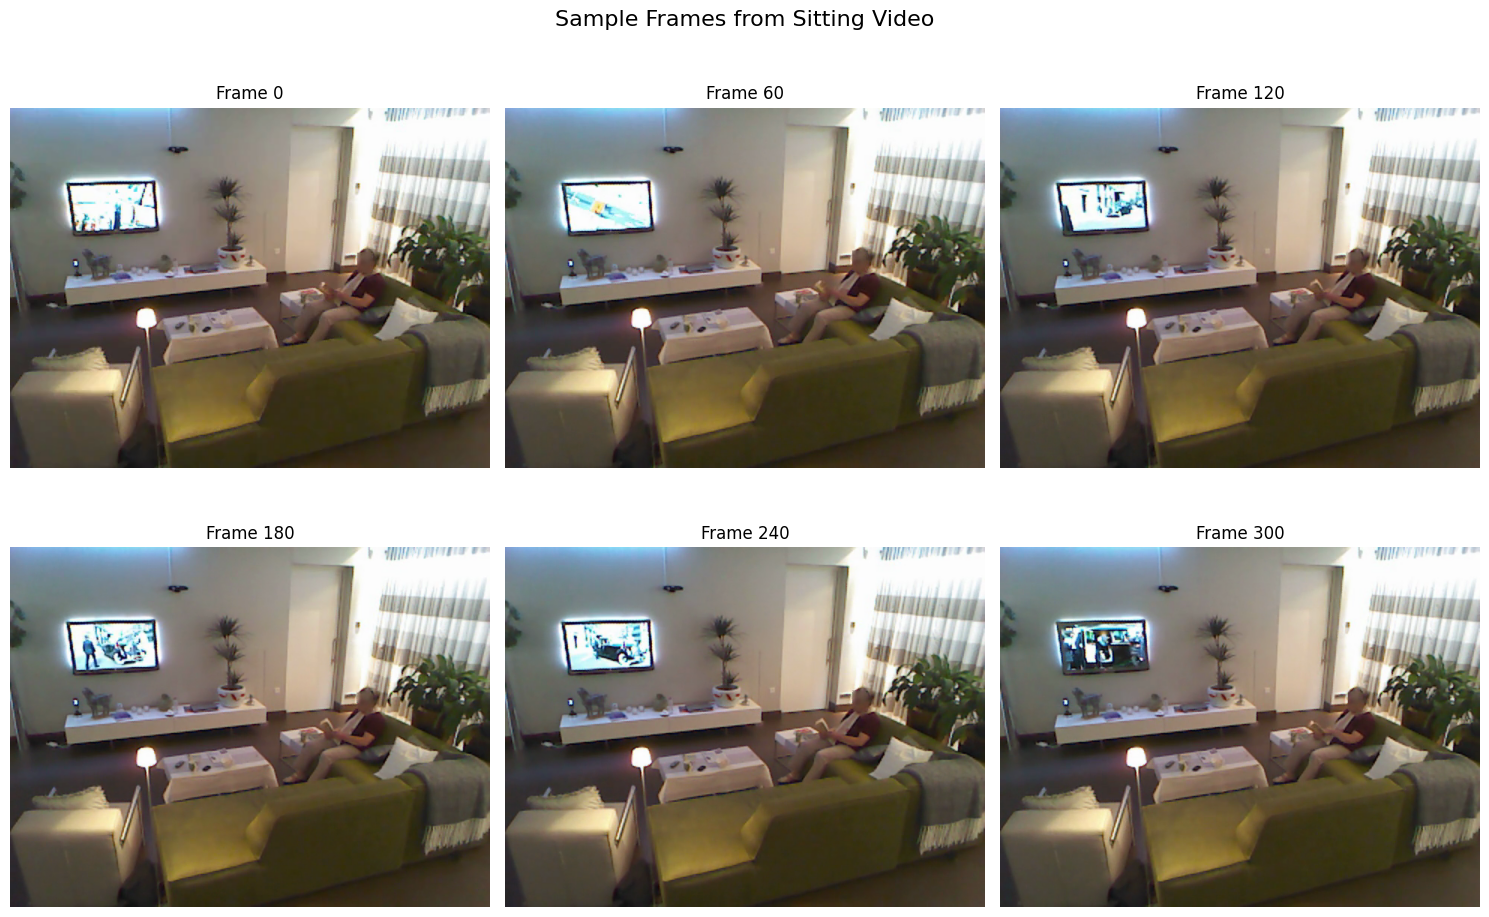

In [19]:
def analyze_sample_video(category="Sitting", sample_index=0):
    """
    Analyze a sample video from the specified category.
    """
    dir_path = f"Data/{category}"

    if not os.path.exists(dir_path):
        print(f"Directory not found: {dir_path}")
        return None

    video_files = [f for f in os.listdir(dir_path) if f.endswith(".mp4")]

    if not video_files:
        print(f"No video files found in {dir_path}")
        return None

    if sample_index >= len(video_files):
        print(f"Sample index {sample_index} out of range. Max: {len(video_files)-1}")
        return None

    video_path = os.path.join(dir_path, video_files[sample_index])
    print(f"Analyzing: {video_files[sample_index]}")

    # Extract frames
    frames = extract_frames_to_array(video_path, sample_rate=60)

    if frames:
        # Clear any existing plots
        plt.close("all")

        # Display first few frames
        num_frames_to_show = min(6, len(frames))
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i in range(num_frames_to_show):
            frame_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"Frame {i*60}")
            axes[i].axis("off")

        # Hide unused subplots
        for i in range(num_frames_to_show, 6):
            axes[i].set_visible(False)

        plt.suptitle(f"Sample Frames from {category} Video", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Clear the figure to prevent it from showing again
        plt.close(fig)

        return frames

    return None


# Test the improved function
sample_frames = analyze_sample_video("Sitting", 0)

## 4. Next Steps

In [11]:
# Import required libraries
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import os
from pathlib import Path

print("✅ Libraries imported successfully!")

# Step 1: Initialize MediaPipe Pose Detection
print("🎯 Step 1: Initializing MediaPipe Pose Detection...")

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Create pose detector with proper error handling
def create_pose_detector():
    """Create and return a MediaPipe pose detector"""
    try:
        pose = mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5
        )
        print("✅ MediaPipe pose detector created successfully!")
        return pose
    except Exception as e:
        print(f"❌ Error creating pose detector: {e}")
        return None

print("✅ MediaPipe utilities initialized!")

# Step 2: Function to detect pose in frames
def detect_pose_in_frames(frames):
    """
    Detect pose keypoints in extracted frames using MediaPipe
    
    Args:
        frames: List of frames from extract_frames_to_array
    
    Returns:
        List of pose detection results
    """
    # Create pose detector
    pose = create_pose_detector()
    if pose is None:
        print("❌ Could not create pose detector")
        return []
    
    pose_results = []
    
    try:
        for i, frame in enumerate(frames):
            print(f"   Processing frame {i+1}/{len(frames)}...")
            
            try:
                # Check if frame is valid
                if frame is None:
                    print(f"     ❌ Frame {i+1} is None")
                    pose_results.append(None)
                    continue
                
                # Convert BGR to RGB (MediaPipe requires RGB)
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Detect pose
                results = pose.process(rgb_frame)
                
                # Store results
                pose_results.append(results)
                
                # Print detection status
                if results.pose_landmarks:
                    print(f"     ✅ Pose detected in frame {i+1}")
                else:
                    print(f"     ❌ No pose detected in frame {i+1}")
                    
            except Exception as e:
                print(f"     ❌ Error processing frame {i+1}: {e}")
                pose_results.append(None)
    
    finally:
        # Close the pose detector
        if pose:
            pose.close()
            print("✅ Pose detector closed")
    
    return pose_results

# Step 3: Function to visualize pose detection
def visualize_pose_detection(frames, pose_results):
    """
    Visualize pose detection results
    
    Args:
        frames: List of original frames
        pose_results: List of MediaPipe pose detection results
    """
    print("🎨 Creating pose visualization...")
    
    # Create subplot for visualization
    n_frames = len(frames)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(min(n_frames, 6)):
        try:
            # Get original frame
            original_frame = frames[i]
            pose_result = pose_results[i] if i < len(pose_results) else None
            
            # Create annotated frame
            annotated_frame = original_frame.copy()
            
            # Convert to RGB for MediaPipe drawing
            rgb_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
            
            # Draw pose landmarks if detected
            if pose_result and pose_result.pose_landmarks:
                mp_drawing.draw_landmarks(
                    rgb_frame,
                    pose_result.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
                )
            
            # Display frame
            axes[i].imshow(rgb_frame)
            
            # Add title with detection status
            if pose_result and pose_result.pose_landmarks:
                axes[i].set_title(f'Frame {i+1} - Pose Detected', color='green', fontsize=12, weight='bold')
                axes[i].text(10, 30, 'Pose Found', color='green', fontsize=10, weight='bold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            else:
                axes[i].set_title(f'Frame {i+1} - No Pose', color='red', fontsize=12, weight='bold')
                axes[i].text(10, 30, 'No Pose', color='red', fontsize=10, weight='bold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            axes[i].axis('off')
            
        except Exception as e:
            print(f"❌ Error visualizing frame {i+1}: {e}")
            axes[i].text(0.5, 0.5, f'Error in Frame {i+1}', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(n_frames, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('MediaPipe Pose Detection Results', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualization created!")

# Step 4: Function to print summary
def print_detection_summary(frames, pose_results):
    """
    Print summary of pose detection results
    """
    print("📊 Pose Detection Summary")
    print("=" * 40)
    
    total_frames = len(frames)
    detected_frames = sum(1 for result in pose_results if result and result.pose_landmarks)
    detection_rate = (detected_frames / total_frames) * 100 if total_frames > 0 else 0
    
    print(f"Total frames analyzed: {total_frames}")
    print(f"Frames with pose detected: {detected_frames}")
    print(f"Detection rate: {detection_rate:.1f}%")
    
    if detected_frames > 0:
        print(f"✅ Pose detection successful!")
    else:
        print(f"❌ No poses detected in any frame")
    
    print("=" * 40)

print("✅ All functions defined! Ready to use with your frames.")

✅ Libraries imported successfully!
🎯 Step 1: Initializing MediaPipe Pose Detection...
✅ MediaPipe utilities initialized!
✅ All functions defined! Ready to use with your frames.


Processing: Walk_p02_r02_v07_c04.mp4 (FPS: 20.0, Duration: 5.3s)
✅ Extracted 2 frames
✅ MediaPipe pose detector created successfully!
   Processing frame 1/2...
     ✅ Pose detected in frame 1
   Processing frame 2/2...
     ❌ No pose detected in frame 2
✅ Pose detector closed
🎨 Creating pose visualization...


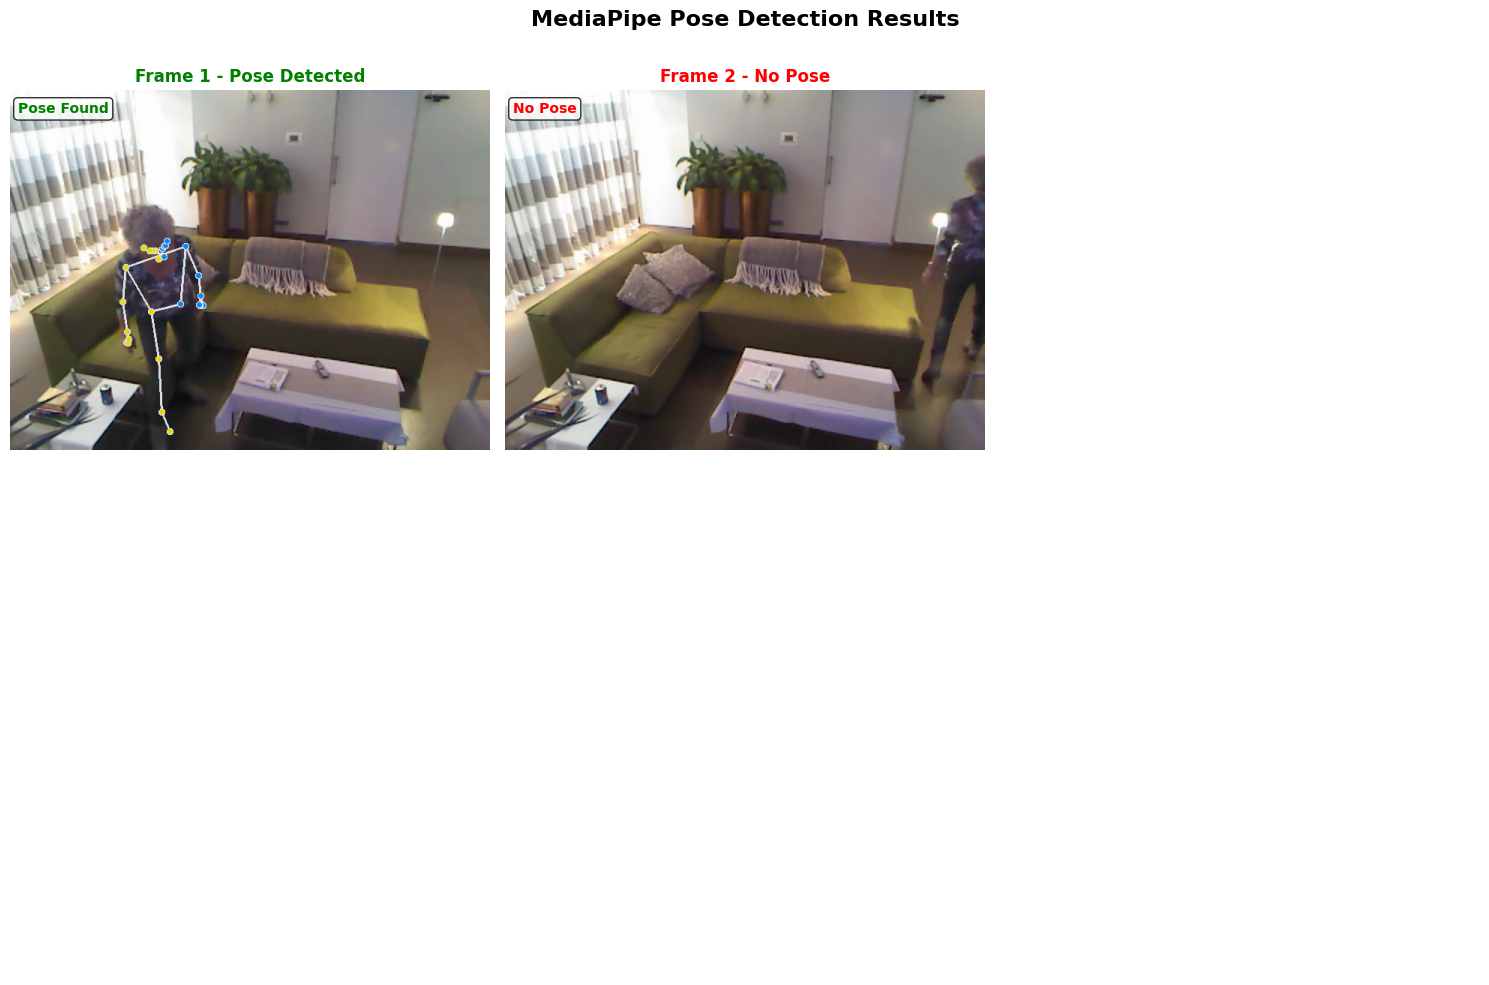

✅ Visualization created!
📊 Pose Detection Summary
Total frames analyzed: 2
Frames with pose detected: 1
Detection rate: 50.0%
✅ Pose detection successful!


In [17]:
# 1. Extract frames using your existing function
video_path = "Data/Standing/Walk_p02_r02_v07_c04.mp4"  # Your video path
frames = extract_frames_to_array(video_path, sample_rate=60)

# 2. Detect pose in frames
pose_results = detect_pose_in_frames(frames)

# 3. Visualize results
visualize_pose_detection(frames, pose_results)

# 4. Print summary
print_detection_summary(frames, pose_results)